In [1]:
from __future__ import annotations

import csv
import json
import logging
import math
import os
from collections import Counter
from functools import cache
from itertools import islice, product
from typing import Any, Optional

from matplotlib import pyplot as plt
from tqdm import tqdm

log = logging.getLogger("aa72")
with open("logging.config.json", "rt") as f:
    logging.config.dictConfig(json.load(f))

N_PIECES = 2000

# Load index as side connection map

The side connection map is used to look up comparison scores between sides.
Sides are identified by `side_id`, which is a single number that combines `piece_id` and `side_idx` as follows:

`side_id = piece_id * 10 + side_idx`

In [2]:
class ExtendedAccessDict(dict):
    def first_value(self) -> tuple[Any, Any]:
        return next(iter(self.values()))

    def first_key(self) -> Any:
        return next(iter(self.keys()))

    def first_values(self, n: int) -> islice:
        return islice(self.values(), n)


log.info("Loading...")
scm = {}
with open(os.path.join("data", "out_03", "index.csv"), "rt") as f:
    reader = csv.reader(f)
    for (
        piece_a_id,
        side_a_idx,
        _,
        piece_b_id,
        side_b_idx,
        _,
        score,
    ) in tqdm(reader):
        side_a_id = int(piece_a_id) * 10 + int(side_a_idx)
        side_b_id = int(piece_b_id) * 10 + int(side_b_idx)

        if side_a_id not in scm:
            scm[side_a_id] = {}
        if side_b_id not in scm:
            scm[side_b_id] = {}

        score = float(score)
        scm[side_a_id][side_b_id] = score
        scm[side_b_id][side_a_id] = score


# I'm relying on the sorted dicts (won't work with anything below Python 3.7)
log.info("Sorting...")
for k in tqdm(scm):
    scm[k] = ExtendedAccessDict(sorted(scm[k].items(), key=lambda item: item[1]))

piece_a_id, side_a_idx = 1, 2
piece_b_id, side_b_idx = 341, 0

a = piece_a_id * 10 + side_a_idx
b = piece_b_id * 10 + side_b_idx

print(f"\n{scm[a][b] = }")
print(f"{scm[b][a] = }")

[2024-02-21 22:21:33][INFO] Loading...


15281314it [00:33, 449670.26it/s]

[2024-02-21 22:22:07][INFO] Sorting...



100%|██████████| 7820/7820 [00:10<00:00, 743.53it/s]


scm[a][b] = 21.55062857836378
scm[b][a] = 21.55062857836378


# Identify flat sides

In [3]:
knobs_and_holes = set(scm.keys())
flat_sides = {
    piece_id * 10 + side_idx
    for piece_id in range(1, N_PIECES + 1)
    for side_idx in range(4)
    if piece_id * 10 + side_idx not in knobs_and_holes
}
flat_sides_count = Counter(side_id // 10 for side_id in flat_sides)

print(f"{flat_sides_count[1] = }")
print(f"{1 * 10 + 0 in flat_sides = }")
print(f"{1 * 10 + 1 in flat_sides = }")
print(f"{1 * 10 + 2 in flat_sides = }")
print(f"{1 * 10 + 3 in flat_sides = }")

flat_sides_count[1] = 2
1 * 10 + 0 in flat_sides = True
1 * 10 + 1 in flat_sides = True
1 * 10 + 2 in flat_sides = False
1 * 10 + 3 in flat_sides = False


# Identify edge/corner/center pieces

In [4]:
corner_pieces = [
    piece_id for piece_id in range(1, N_PIECES + 1) if flat_sides_count[piece_id] == 2
]
corner_pieces

[1, 40, 1134, 1921]

In [5]:
edge_pieces = {
    piece_id for piece_id in range(1, N_PIECES + 1) if flat_sides_count[piece_id] == 1
}
set(islice(edge_pieces, 10))

{2, 3, 4, 5, 6, 7, 8, 9, 10, 1024}

In [6]:
center_pieces = {
    piece_id for piece_id in range(1, N_PIECES + 1) if flat_sides_count[piece_id] == 0
}
set(islice(center_pieces, 10))

{41, 42, 43, 44, 45, 46, 47, 48, 49, 50}

# Ivestigate connection scores

## Worst of best scores

Find the optimal matches for each side, then check the worst matches within that selection.


In [7]:
_n_worst_pieces_to_check = 10
_n_matches_to_check_per_piece = 10

scm_from_worst = dict(
    sorted(
        scm.items(),
        key=lambda item: item[1].first_value(),
        reverse=True,
    )
)

for side_a_id in islice(scm_from_worst, _n_worst_pieces_to_check):
    print(f"side_a = {divmod(side_a_id, 10)}")

    for side_b_id, score in islice(
        scm_from_worst[side_a_id].items(),
        _n_matches_to_check_per_piece,
    ):
        print(f"  side_b = {divmod(side_b_id, 10)} {score = :.3f}")

side_a = (187, 1)
  side_b = (1300, 0) score = 5.370
  side_b = (767, 1) score = 5.652
  side_b = (769, 2) score = 5.699
  side_b = (819, 3) score = 5.880
  side_b = (1309, 3) score = 5.923
  side_b = (415, 0) score = 6.101
  side_b = (389, 2) score = 6.182
  side_b = (647, 0) score = 6.187
  side_b = (1796, 0) score = 6.188
  side_b = (1767, 0) score = 6.431
side_a = (1503, 1)
  side_b = (1315, 3) score = 5.240
  side_b = (1642, 2) score = 6.915
  side_b = (1321, 1) score = 6.959
  side_b = (516, 1) score = 7.174
  side_b = (841, 0) score = 7.216
  side_b = (291, 0) score = 7.545
  side_b = (1893, 2) score = 7.805
  side_b = (1393, 0) score = 7.975
  side_b = (1044, 1) score = 7.996
  side_b = (304, 0) score = 8.007
side_a = (1315, 3)
  side_b = (1503, 1) score = 5.240
  side_b = (63, 3) score = 5.711
  side_b = (239, 1) score = 6.113
  side_b = (1885, 1) score = 6.148
  side_b = (108, 3) score = 6.869
  side_b = (702, 0) score = 7.040
  side_b = (1181, 3) score = 7.040
  side_b = (17

Correct matches verified manually:

- 187 + 769 (3rd match)
- 1503 + 1315 (1st match)
- 1315 + 1503 (1st match)
- 40 + 1334 (3rd match)
- 1328 + 973 (1st match)
- 973 + 1328 (1st match)
- 1334 + 40 (9th match)
- 858 + 16 (5th match)
- 1 + 1896 (1st match)
- 1896 + 1 (1st match)


## Best of best scores

Find the optimal matches for each side, then analyze the best matches within that selection.


In [8]:
_n_best_pieces_to_check = 10
_n_matches_to_check_per_piece = 10

scm_from_best = dict(
    sorted(
        scm.items(),
        key=lambda item: item[1].first_value(),
        reverse=False,
    )
)

for side_a_id in islice(scm_from_best, _n_best_pieces_to_check):
    print(f"side_a = {divmod(side_a_id, 10)}")

    for side_b_id, score in islice(
        scm_from_best[side_a_id].items(),
        _n_matches_to_check_per_piece,
    ):
        print(f"  side_b = {divmod(side_b_id, 10)} {score = :.3f}")

side_a = (469, 3)
  side_b = (64, 3) score = 0.983
  side_b = (1100, 1) score = 2.370
  side_b = (1050, 1) score = 2.398
  side_b = (768, 0) score = 2.565
  side_b = (1467, 0) score = 2.640
  side_b = (803, 2) score = 2.760
  side_b = (950, 0) score = 2.796
  side_b = (413, 0) score = 2.815
  side_b = (682, 2) score = 2.827
  side_b = (168, 2) score = 3.027
side_a = (64, 3)
  side_b = (469, 3) score = 0.983
  side_b = (449, 3) score = 2.136
  side_b = (1961, 1) score = 2.286
  side_b = (514, 1) score = 2.406
  side_b = (1369, 3) score = 2.537
  side_b = (1482, 1) score = 2.723
  side_b = (1050, 3) score = 2.813
  side_b = (1146, 3) score = 2.861
  side_b = (1514, 3) score = 2.865
  side_b = (571, 3) score = 2.937
side_a = (585, 3)
  side_b = (625, 0) score = 1.008
  side_b = (1383, 0) score = 2.075
  side_b = (143, 0) score = 2.760
  side_b = (683, 0) score = 2.907
  side_b = (439, 0) score = 3.019
  side_b = (439, 2) score = 3.177
  side_b = (1280, 1) score = 3.534
  side_b = (1688, 2

Correct matches verified manually:

- 469 + 64 (1st match)
- 64 + 469 (1st match)
- 585 + 625 (1st match)
- 625 + 585 (1st match)
- 568 + 165 (1st match)
- 165 + 568 (1st match)
- 330 + 585 (1st match)
- 585 + 330 (1st match)
- 864 + 867 (1st match)
- 867 + 864 (1st match)


## Best scores distribution

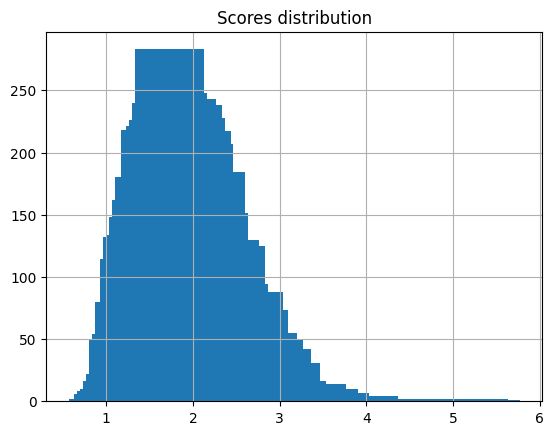

In [9]:
best_scores = [scm[side_a_id].first_value() for side_a_id in scm]

_resolution = 30
binned_scores = [round(_resolution * score) / _resolution for score in best_scores]

ax = plt.gca()
ax.grid()
ax.set_title("Scores distribution")
_ = ax.bar(*zip(*sorted(Counter(binned_scores).items())))

The wide range of scores, ranging from approximately 0.5 to over 5.5, is undesirable. Ideally, the score distribution should be as narrow as possible. Some of the worst scores still mean a match and they should be 'worth' roughly the same as any other match. In order to reduce the width of the distribution, scores should be scaled by `log10`, `ln` or `sqrt`.

## Most picked sides

In [10]:
pick_counter = Counter(next(iter(scm[side_a_id].keys())) for side_a_id in scm)
for side_id, picked in pick_counter.most_common(20):
    print(f"{side_id = } {picked = }")

side_id = 19521 picked = 6
side_id = 3553 picked = 6
side_id = 4290 picked = 5
side_id = 9172 picked = 4
side_id = 17833 picked = 4
side_id = 9293 picked = 4
side_id = 2150 picked = 4
side_id = 4493 picked = 4
side_id = 14411 picked = 4
side_id = 2441 picked = 4
side_id = 9111 picked = 4
side_id = 12893 picked = 4
side_id = 15220 picked = 3
side_id = 16183 picked = 3
side_id = 4243 picked = 3
side_id = 7680 picked = 3
side_id = 12650 picked = 3
side_id = 11902 picked = 3
side_id = 19502 picked = 3
side_id = 7671 picked = 3


If matches were calculated perfectly, each side would be picked only once. Consequently, many matches are not reciprocal (side a matches side b, but side b doesn't match side a).

# Scale the scores

Initially, I attempted to solve the jigsaw puzzle without scaling the scores, but it didn't work well. I decided to scale the scores by `log10`.


In [11]:
for piece_a in tqdm(scm):
    for piece_b in scm[piece_a]:
        scm[piece_a][piece_b] = math.log10(1 + float(scm[piece_a][piece_b]))

100%|██████████| 7820/7820 [00:12<00:00, 634.53it/s]


# Solution

In [12]:
# I'll take advantage of knowing the dimensions of the puzzle
N_ROWS = 50
N_COLS = 40

# The solution is depicted as a nested list of pieces, with each piece itself being a list of sides.
# The first element in the list denotes the side pointing upwards, the second represents the left side,
# the third corresponds to the bottom, and the fourth indicates the right side. This representation
# enables easy rotation by shifting the first element to the end of the list (or vice versa).
TOP = 0
LEFT = 1
BOTTOM = 2
RIGHT = 3


# Caching side_ids allows to ensure that the same object is always returned for given parameters
@cache
def make_side_ids(
    piece_id: int,
    top: Optional[str | int] = None,
    left: Optional[str | int] = None,
    bottom: Optional[str | int] = None,
    right: Optional[str | int] = None,
) -> list[int]:
    piece = [piece_id * 10 + side_idx for side_idx in range(4)]
    # Rotate list of side ids until all conditions are met
    # fmt: off
    while not (
            (True if top    is None else piece[TOP] in flat_sides    if top == "flat"    else top == piece[TOP])
        and (True if left   is None else piece[LEFT] in flat_sides   if left == "flat"   else left == piece[LEFT])
        and (True if bottom is None else piece[BOTTOM] in flat_sides if bottom == "flat" else bottom == piece[BOTTOM])
        and (True if right  is None else piece[RIGHT] in flat_sides  if right == "flat"  else right == piece[RIGHT])
    ):
        piece.append(piece.pop(0))
    # fmt: on
    return tuple(piece)


def left_of(side_id: int) -> int:
    piece_id, side_idx = divmod(side_id, 10)
    return piece_id * 10 + (side_idx + 1) % 4


def opposite_of(side_id: int) -> int:
    piece_id, side_idx = divmod(side_id, 10)
    return piece_id * 10 + (side_idx + 2) % 4


def right_of(side_id: int) -> int:
    piece_id, side_idx = divmod(side_id, 10)
    return piece_id * 10 + (side_idx + 3) % 4


class SolvingFailedError(Exception):
    """Exception raised when no puzzle piece can be placed."""


INF = float("inf")

## First

I split the puzzle into 9 parts. Each part has its own rules for edges (flat sides) and scores. I add one piece at a time to the solution, starting from the top-left and moving to the bottom-right.

Here are the sections:

<pre>
 ┌─┬───────────┬─┐
 │0│     1     │2│
 ├─┼───────────┼─┤
 │ │           │ │
 │ │           │ │
 │ │           │ │
 │3│     4     │5│
 │ │           │ │
 │ │           │ │
 │ │           │ │
 ├─┼───────────┼─┤
 │6│     7     │8│
 └─┴───────────┴─┘
</pre>

0. Top left corner. First piece of the puzzle. I'll take the advantage of already knowing this one.
1. First row without first and last pieces. The middle of the top puzzle edge.
2. Top right corner.
3. Left column without first and last pieces. The middle of the left puzzle edge.
4. Center of the puzzle. All pieces besides frame.
5. Right column without first and last pieces. The middle of the right puzzle edge.
6. Bottom left corner.
7. Last row without first and last pieces. The middle of the bottom puzzle edge.
8. Bottom right corner. Last piece of the puzzle.

Each section has its own rules for edges. Additionally, across the entire puzzle, knobs only fit into holes, and vice versa. If a wrong piece is placed early on, we might not find suitable pieces later, as knobs can't connect to knobs and holes can't connect to holes. In such a scenario, the process stops early with an exception.

I assumed that the first attempt may not succeed without manual intervention, so I implemented an exclusion list. If a piece is listed in the exclusion list for a certain position, it won't be placed there. This flexibility allows for manual adjustments during the assembly process.

Although relying solely on the comparison index could suffice, additional edge rules help prevent obvious mistakes.


In [13]:
# fmt: off
excluded = {
    (1456, 1, 7),
    (1936, 1, 7),
    (1621, 1, 10),
    (1805, 1, 13),

    # Piece 1246 seems to cause the biggest issues
    (947,  1, 14), (1032, 1, 14), (1522, 1, 14), (1612, 1, 14), (878,  1, 14),
    (547,  1, 14), (1289, 1, 14), (1369, 1, 14), (1908, 1, 14), (1492, 1, 14),
    (1072, 1, 14), (1994, 1, 14), (1380, 1, 14), (1416, 1, 14), (655,  1, 14),
    (1615, 1, 14), (359,  1, 14), (413,  1, 14), (1678, 1, 14), (1383, 1, 14),
    (994,  1, 14), (1107, 1, 14), (1851, 1, 14), (393,  1, 14), (768,  1, 14),
    (1995, 1, 14), (1410, 1, 14), (1530, 1, 14), (803,  1, 14), (495,  1, 14),
    (252,  1, 14), (1979, 1, 14), (894,  1, 14), (1486, 1, 14), (1479, 1, 14),
    (1063, 1, 14), (625,  1, 14), (1482, 1, 14), (1961, 1, 14), (846,  1, 14),
    (123,  1, 14), (143,  1, 14), (865,  1, 14), (1132, 1, 14), (1351, 1, 14),
    (941,  1, 14), (56,   1, 14), (184,  1, 14), (1993, 1, 14), (683,  1, 14),
    (906,  1, 14),

    (559,  1, 31),
    (1627, 1, 31),
}
# fmt: on


# To simplify the process, I'll initialize the solution right away.
# This wouldn't be possible if I didn't know the dimensions and first corner piece.
solution = [[None] * N_COLS for _ in range(N_ROWS)]
placed = set()

log.info("Solving...")
try:
    # First row

    # Section 0

    row, col = 0, 0
    solution[row][col] = make_side_ids(piece_id=1, top="flat", left="flat")
    placed.add(1)

    # Section 1

    row = 0
    for col in range(1, N_COLS - 1):
        on_left = solution[row][col - 1][RIGHT]

        best_score, best_match_left = INF, None
        for top_side_id in flat_sides:
            piece_id = top_side_id // 10
            left_side_id = left_of(top_side_id)

            if (
                piece_id in placed
                or piece_id not in edge_pieces
                or left_side_id not in scm[on_left]
                or (piece_id, row, col) in excluded
            ):
                continue

            score = scm[on_left][left_side_id]
            if score < best_score:
                best_score, best_match_left = score, left_side_id

        if best_match_left is None:
            raise SolvingFailedError()

        solution[row][col] = make_side_ids(piece_id=best_match_left // 10, top="flat")
        placed.add(best_match_left // 10)

    # Section 2

    row = 0
    col = N_COLS - 1
    on_left = solution[row][col - 1][RIGHT]

    best_score, best_match_left = INF, None
    for top_side_id in flat_sides:
        piece_id = top_side_id // 10
        left_side_id = left_of(top_side_id)

        if (
            piece_id in placed
            or piece_id not in corner_pieces
            or left_side_id not in scm[on_left]
            or (piece_id, row, col) in excluded
        ):
            continue

        score = scm[on_left][left_side_id]
        if score < best_score:
            best_score, best_match_left = score, left_side_id

    if best_match_left is None:
        raise SolvingFailedError()

    solution[row][col] = make_side_ids(piece_id=best_match_left // 10, top="flat")
    placed.add(best_match_left // 10)

    # Middle rows

    for row in range(1, N_ROWS - 1):
        # Section 3

        col = 0
        on_top = solution[row - 1][col][BOTTOM]

        best_score, best_match_top = INF, None
        for left_side_id in flat_sides:
            piece_id = left_side_id // 10
            top_side_id = right_of(left_side_id)

            if (
                piece_id in placed
                or piece_id not in edge_pieces
                or top_side_id not in scm[on_top]
                or (piece_id, row, col) in excluded
            ):
                continue

            score = scm[on_top][top_side_id]
            if score < best_score:
                best_score, best_match_top = score, top_side_id

        if best_match_top is None:
            raise SolvingFailedError()

        solution[row][col] = make_side_ids(piece_id=best_match_top // 10, left="flat")
        placed.add(best_match_top // 10)

        # Section 4

        for col in range(1, N_COLS - 1):
            on_top = solution[row - 1][col][BOTTOM]
            on_left = solution[row][col - 1][RIGHT]

            best_score, best_match_top = INF, None
            for top_side_id in scm[on_top]:
                piece_id = top_side_id // 10
                left_side_id = left_of(top_side_id)

                if (
                    piece_id in placed
                    or piece_id not in center_pieces
                    or left_side_id not in scm[on_left]
                    or (piece_id, row, col) in excluded
                ):
                    continue

                score = scm[on_top][top_side_id] + scm[on_left][left_side_id]
                if score < best_score:
                    best_score, best_match_top = score, top_side_id

            if best_match_top is None:
                raise SolvingFailedError()

            solution[row][col] = make_side_ids(piece_id=best_match_top // 10, top=best_match_top)  # fmt: skip
            placed.add(best_match_top // 10)

        # Section 5

        col = N_COLS - 1
        on_top = solution[row - 1][col][BOTTOM]
        on_left = solution[row][col - 1][RIGHT]

        best_score, best_match_top = INF, None
        for right_side_id in flat_sides:
            piece_id = right_side_id // 10
            top_side_id = left_of(right_side_id)
            left_side_id = left_of(top_side_id)

            if (
                piece_id in placed
                or piece_id not in edge_pieces
                or top_side_id not in scm[on_top]
                or left_side_id not in scm[on_left]
                or (piece_id, row, col) in excluded
            ):
                continue

            score = scm[on_top][top_side_id] + scm[on_left][left_side_id]
            if score < best_score:
                best_score, best_match_top = score, top_side_id

        if best_match_top is None:
            raise SolvingFailedError()

        solution[row][col] = make_side_ids(piece_id=best_match_top // 10, right="flat")
        placed.add(best_match_top // 10)

    # Last row

    # Section 6

    row = N_ROWS - 1
    col = 0
    on_top = solution[row - 1][col][BOTTOM]

    best_score, best_match_top = INF, None
    for left_side_id in flat_sides:
        piece_id = left_side_id // 10
        top_side_id = right_of(left_side_id)

        if (
            piece_id in placed
            or piece_id not in corner_pieces
            or top_side_id not in scm[on_top]
            or (piece_id, row, col) in excluded
        ):
            continue

        score = scm[on_top][top_side_id]
        if score < best_score:
            best_score, best_match_top = score, top_side_id

    if best_match_top is None:
        raise SolvingFailedError()

    solution[row][col] = make_side_ids(piece_id=best_match_top // 10, top=best_match_top)  # fmt: skip
    placed.add(best_match_top // 10)

    # Section 7

    row = N_ROWS - 1
    for col in range(1, N_COLS - 1):
        on_top = solution[row - 1][col][BOTTOM]
        on_left = solution[row][col - 1][RIGHT]

        best_score, best_match_top = INF, None
        for top_side_id in scm[on_top]:
            piece_id = top_side_id // 10
            left_side_id = left_of(top_side_id)

            if (
                piece_id in placed
                or piece_id not in edge_pieces
                or left_side_id not in scm[on_left]
                or (piece_id, row, col) in excluded
            ):
                continue

            score = scm[on_top][top_side_id] + scm[on_left][left_side_id]
            if score < best_score:
                best_score, best_match_top = score, top_side_id

        if best_match_top is None:
            raise SolvingFailedError()

        solution[row][col] = make_side_ids(piece_id=best_match_top // 10, top=best_match_top)  # fmt: skip
        placed.add(best_match_top // 10)

    # Section 8

    row = N_ROWS - 1
    col = N_COLS - 1
    on_top = solution[row - 1][col][BOTTOM]
    on_left = solution[row][col - 1][RIGHT]

    best_score, best_match_top = INF, None
    for right_side_id in flat_sides:
        piece_id = right_side_id // 10
        top_side_id = left_of(right_side_id)
        left_side_id = left_of(top_side_id)

        if (
            piece_id in placed
            or piece_id not in corner_pieces
            or top_side_id not in scm[on_top]
            or left_side_id not in scm[on_left]
            or (piece_id, row, col) in excluded
        ):
            continue

        score = scm[on_top][top_side_id] + scm[on_left][left_side_id]
        if score < best_score:
            best_score, best_match_top = score, top_side_id

    if best_match_top is None:
        raise SolvingFailedError()

    solution[row][col] = make_side_ids(piece_id=best_match_top // 10, top=best_match_top)  # fmt: skip
    placed.add(best_match_top // 10)

    log.info("Solving finished")
except SolvingFailedError:
    log.error(f"Solution failed on {row = }, {col = }")


# Display solution on a grid

print(" " * 10, end="")
for col_idx in range(N_COLS):
    print(f"{col_idx:>5d}", end="")
print()
print()

for row_idx, solution_row in enumerate(solution):
    print(f"{row_idx:>5d}" + " " * 5, end="")
    for solution_cell in solution_row:
        if solution_cell is None:
            break
        piece_id = solution_cell[0] // 10
        print(f"{piece_id:>5d}", end="")
    print()

[2024-02-21 22:25:07][INFO] Solving...
[2024-02-21 22:25:12][INFO] Solving finished
              0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39

    0         1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40
    1      1896  241  453  280 1328  973 1672 1003  864  867  868 1103 1104 1247 1246  858  859  860 1144 1317 1289 1270 1045  742 1895 1650  388  533  539  181  121  417  593  505   60  126  551  515  666 1334
    2      1873  631  131 1677 1926  740 1936 1422 1029 1842 1681 1101 1102 1155 1280 1508 1699  952  752 1533 1035 1461 1428 1057 1676 1552 1319  619  182  364  115  375  594  457   84  228  676  272  392 1331
    3      1168  285  225 1573 1072 1329  837 1291 1073 1217  791 1502 

### Compare to ground truth from csv

This allows to quickly verify the solution in case of a code alterations.

In [14]:
with open("solution.csv") as f:
    reader = csv.reader(f)
    source_of_truth = [[int(piece_id) for piece_id in row] for row in reader]

for row, col in product(range(N_ROWS), range(N_COLS)):
    piece_id = solution[row][col][0] // 10
    expected = source_of_truth[row][col]
    if piece_id != expected:
        log.error(f"Missmatch on {row = }, {col = }; {piece_id = }, {expected = }")
        break

## Second

Here, I refine the initial solution to make it more concise and adaptable. In the second iteration, rather than tackling each section independently, I preprocess the comparison map for each section, enabling me to handle everything within a single loop and enforce the same rules as previously.

This solution does not introduce any additional rules, so the result (and the exclusion set) stays the same.


In [15]:
# fmt: off
allowed_per_section = [
    None,
    {make_side_ids(piece_id=side_id // 10, top=side_id) for side_id in flat_sides if side_id // 10 in edge_pieces},
    {make_side_ids(piece_id=side_id // 10, top=side_id) for side_id in flat_sides if right_of(side_id) in flat_sides},
    {make_side_ids(piece_id=side_id // 10, left=side_id) for side_id in flat_sides if side_id // 10 in edge_pieces},
    {make_side_ids(piece_id=side_id // 10, left=side_id) for side_id in scm if side_id // 10 in center_pieces},
    {make_side_ids(piece_id=side_id // 10, right=side_id) for side_id in flat_sides if side_id // 10 in edge_pieces},
    {make_side_ids(piece_id=side_id // 10, left=side_id) for side_id in flat_sides if left_of(side_id) in flat_sides},
    {make_side_ids(piece_id=side_id // 10, bottom=side_id) for side_id in flat_sides if side_id // 10 in edge_pieces},
    {make_side_ids(piece_id=side_id // 10, right=side_id) for side_id in flat_sides if right_of(side_id) in flat_sides},
]
# fmt: on


def section(row: int, col: int) -> int:
    r = 0 if row == 0 else 3 if 0 < row < N_ROWS - 1 else 6
    c = 0 if col == 0 else 1 if 0 < col < N_COLS - 1 else 2
    return r + c


allowed = [
    [allowed_per_section[section(row, col)] for col in range(N_COLS)]
    for row in range(N_ROWS)
]


solution = [[None] * N_COLS for _ in range(N_ROWS)]
placed = set()

log.info("Solving...")
try:
    positions = product(range(N_ROWS), range(N_COLS))

    # Section 0

    row, col = next(positions)
    solution[row][col] = make_side_ids(piece_id=1, top="flat", left="flat")
    placed.add(1)

    # The rest

    for row, col in tqdm(positions):
        best_score, best_match, best_piece_id = INF, None, None

        for piece in allowed[row][col]:
            piece_id = piece[0] // 10

            if piece_id in placed or (piece_id, row, col) in excluded:
                continue

            score = 0.0

            if row > 0:
                piece_on_top = solution[row - 1][col]
                if piece[TOP] not in scm[piece_on_top[BOTTOM]]:
                    continue
                score += scm[piece_on_top[BOTTOM]][piece[TOP]]

            if col > 0:
                piece_on_left = solution[row][col - 1]
                if piece[LEFT] not in scm[piece_on_left[RIGHT]]:
                    continue
                score += scm[piece_on_left[RIGHT]][piece[LEFT]]

            if score < best_score:
                best_score, best_match, best_piece_id = score, piece, piece_id

        if best_match is None:
            raise SolvingFailedError()
        solution[row][col] = best_match
        placed.add(best_piece_id)

    log.info("Solving finished")
except SolvingFailedError:
    log.error(f"Solution failed on {row = }, {col = }")


# Display solution on a grid

print(" " * 10, end="")
for col_idx in range(N_COLS):
    print(f"{col_idx:>5d}", end="")
print()
print()

for row_idx, solution_row in enumerate(solution):
    print(f"{row_idx:>5d}" + " " * 5, end="")
    for solution_cell in solution_row:
        if solution_cell is None:
            break
        piece_id = solution_cell[0] // 10
        print(f"{piece_id:>5d}", end="")
    print()

[2024-02-21 22:25:22][INFO] Solving...


1999it [00:07, 254.83it/s]

[2024-02-21 22:25:30][INFO] Solving finished
              0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39

    0         1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40
    1      1896  241  453  280 1328  973 1672 1003  864  867  868 1103 1104 1247 1246  858  859  860 1144 1317 1289 1270 1045  742 1895 1650  388  533  539  181  121  417  593  505   60  126  551  515  666 1334
    2      1873  631  131 1677 1926  740 1936 1422 1029 1842 1681 1101 1102 1155 1280 1508 1699  952  752 1533 1035 1461 1428 1057 1676 1552 1319  619  182  364  115  375  594  457   84  228  676  272  392 1331
    3      1168  285  225 1573 1072 1329  837 1291 1073 1217  791 1502  919 1173 1174  982 1801 1545  813 1487

### Compare to ground truth from csv

This allows to quickly verify the solution in case of a code alterations.

In [16]:
with open("solution.csv") as f:
    reader = csv.reader(f)
    source_of_truth = [[int(piece_id) for piece_id in row] for row in reader]

for row, col in product(range(N_ROWS), range(N_COLS)):
    piece_id = solution[row][col][0] // 10
    expected = source_of_truth[row][col]
    if piece_id != expected:
        log.error(f"Missmatch on {row = }, {col = }; {piece_id = }, {expected = }")
        break

## Third

This attempt builds on the second iteration of the solution and introduces additional rules. When placing a piece I'm also trying to temporarily place piece to the bottom and bottom left (if possible). When I calculate the score I add half of the *extra score*. The rest of the solution remains the same.

This approach is much slower, but seems to be more accurate, since it required less manual interventions via exclusion set.


In [18]:
solution = [[None] * N_COLS for _ in range(N_ROWS)]
placed = set()

excluded = {
    (1805, 1, 13),
}

log.info("Solving...")
try:
    positions = product(range(N_ROWS), range(N_COLS))

    # Section 0

    row, col = next(positions)
    solution[row][col] = make_side_ids(piece_id=1, top="flat", left="flat")
    placed.add(1)

    # The rest

    for row, col in tqdm(positions):
        best_score, best_match, best_piece_id = INF, None, None

        for piece in allowed[row][col]:
            piece_id = piece[0] // 10

            if piece_id in placed or (piece_id, row, col) in excluded:
                continue

            score = 0.0

            if row > 0:
                piece_on_top = solution[row - 1][col]
                if piece[TOP] not in scm[piece_on_top[BOTTOM]]:
                    continue
                score += scm[piece_on_top[BOTTOM]][piece[TOP]]

            if col > 0:
                piece_on_left = solution[row][col - 1]
                if piece[LEFT] not in scm[piece_on_left[RIGHT]]:
                    continue
                score += scm[piece_on_left[RIGHT]][piece[LEFT]]

            # A little bit of optimisation
            if score > best_score:
                continue

            # Additional rules
            if row < N_ROWS - 1 and col > 0:
                best_extra_score = INF

                # To bring execution time down to a managable number,
                # I'll go through 50 best matches for bottom and bottom left pieces.
                for bt, blt in product(
                    islice(scm[piece[BOTTOM]], 50),
                    islice(scm[piece_on_left[BOTTOM]], 50),
                ):
                    bottom_piece = make_side_ids(piece_id=bt // 10, top=bt)
                    bottom_left_piece = make_side_ids(piece_id=blt // 10, top=blt)

                    if bottom_piece not in allowed[row + 1][col]:
                        continue
                    if bottom_left_piece not in allowed[row + 1][col - 1]:
                        continue
                    if bottom_piece[LEFT] not in scm[bottom_left_piece[RIGHT]]:
                        continue

                    bottom_score = scm[piece_on_left[BOTTOM]][bottom_left_piece[TOP]]
                    bottom_score += scm[piece[BOTTOM]][bottom_piece[TOP]]
                    bottom_score += scm[bottom_piece[LEFT]][bottom_left_piece[RIGHT]]

                    if bottom_score < best_extra_score:
                        best_extra_score = bottom_score

                score += best_extra_score * 0.5

            if score < best_score:
                best_score, best_match, best_piece_id = score, piece, piece_id

        if best_match is None:
            raise SolvingFailedError()
        solution[row][col] = best_match
        placed.add(best_piece_id)

    log.info("Solving finished")
except SolvingFailedError:
    log.error(f"Solution failed on {row = }, {col = }")


# Display solution on a grid

print(" " * 10, end="")
for col_idx in range(N_COLS):
    print(f"{col_idx:>5d}", end="")
print()
print()

for row_idx, solution_row in enumerate(solution):
    print(f"{row_idx:>5d}" + " " * 5, end="")
    for solution_cell in solution_row:
        if solution_cell is None:
            break
        piece_id = solution_cell[0] // 10
        print(f"{piece_id:>5d}", end="")
    print()

[2024-02-21 22:26:03][INFO] Solving...


1999it [23:34,  1.41it/s]

[2024-02-21 22:49:38][INFO] Solving finished
              0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39

    0         1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40
    1      1896  241  453  280 1328  973 1672 1003  864  867  868 1103 1104 1247 1246  858  859  860 1144 1317 1289 1270 1045  742 1895 1650  388  533  539  181  121  417  593  505   60  126  551  515  666 1334
    2      1873  631  131 1677 1926  740 1936 1422 1029 1842 1681 1101 1102 1155 1280 1508 1699  952  752 1533 1035 1461 1428 1057 1676 1552 1319  619  182  364  115  375  594  457   84  228  676  272  392 1331
    3      1168  285  225 1573 1072 1329  837 1291 1073 1217  791 1502  919 1173 1174  982 1801 1545  813 1487

### Compare to ground truth from csv

This allows to quickly verify the solution in case of a code alterations.

In [19]:
with open("solution.csv") as f:
    reader = csv.reader(f)
    source_of_truth = [[int(piece_id) for piece_id in row] for row in reader]

for row, col in product(range(N_ROWS), range(N_COLS)):
    piece_id = solution[row][col][0] // 10
    expected = source_of_truth[row][col]
    if piece_id != expected:
        log.error(f"Missmatch on {row = }, {col = }; {piece_id = }, {expected = }")
        break